Import packages

In [3]:
#Sampling and GSA
from SALib.sample import saltelli
from SALib.analyze import sobol
import sobol_seq
import ghalton
from pyDOE import *
#Rbf
from scipy.interpolate import Rbf
#Plot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#Deal with array and matrix
import numpy as np 
#Read csv
import csv
import pandas as pd
import xlsxwriter
#rbf
from scipy.interpolate import Rbf
#remove file
import os

In [4]:
num = 3		#Number of variables. e.g. 3
num_samples_simulation = 100	 #Number of samples for simulation e.g. 100
method = 'halton'		#Method for input simulation sampling

skip = '' 		#For sobol method, default='', e.g. 3
seed = ''		#For halton method, default='', e.g. 3
latin_criterion = 'default'		#For latin_hypercube method, default='default'. Alternatives: 'center','maximin','centermaximin','correlation'

variablenames = ['rotor_core_stiffness','bearing_stiffness','foundation_stiffness']		
bounds = [[1e8,3e8],[4e8,8e8],[0.5e9,1.5e9]] 	
#rbf
k_fold = 10 	#For k-fold cross-validation
names = ['P5','P6','P7']
rbf_function = 'multiquadric' #Alternatives: 'multiquadric'(default),'inverse','gaussian','linear','cubic','quintic','thin_plate'

#saltelli
saltelli_second_order = False 
num_samples_saltelli = 500	

Sampling

In [5]:
sample_values={}
#sampling
if method == 'sobol':
#Sobol
	if skip != '' :
		skip = int(skip)
		vec = sobol_seq.i4_sobol_generate(num,num_samples_simulation,skip)
		for i in range(num):
			sample_values[variablenames[i]]=list(vec[:,i])
	else:
		skip = 0
		vec = sobol_seq.i4_sobol_generate(num,num_samples_simulation)
		for i in range(num):
			sample_values[variablenames[i]]=list(vec[:,i])
	with open('input.csv','w',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(['method',method,'num variables',num,'num samples',num_samples_simulation,'skip property',skip])
		writer.writerow(sample_values.keys())
		writer.writerows(zip(*sample_values.values()))

#Halton
elif method == 'halton':
	if seed != '' :	
		seed = int(seed)
		sequencer = ghalton.GeneralizedHalton(num,seed)
		points = sequencer.get(num_samples_simulation)
		for i in range(num):
			sample_values[variablenames[i]]=np.array(points)[:,i]
	else:
		sequencer = ghalton.GeneralizedHalton(num)
		points = sequencer.get(num_samples_simulation)
		for i in range(num):
			sample_values[variablenames[i]]=np.array(points)[:,i]
	with open('input.csv','w',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(['method',method,'num variables',num,'num samples',num_samples_simulation,'seed',seed])
		writer.writerow(sample_values.keys())
		writer.writerows(zip(*sample_values.values()))
#Latin hypercube
elif method == 'latin':
	if latin_criterion == 'default':
		latin = lhs(num, samples=num_samples_simulation)
		for i in range(num):
			sample_values[variablenames[i]]=list(latin[:,i])
	else:
		latin = lhs(num, samples=num_samples_simulation,criterion=latin_criterion)
		for i in range(num):
			sample_values[variablenames[i]]=list(latin[:,i])
	with open('input.csv','w',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(['method',method,'num variables',num,'num samples',num_samples_simulation,'criterion',latin_criterion])
		writer.writerow(sample_values.keys())
		writer.writerows(zip(*sample_values.values()))
else:
	print('Please type the correct method name !(sobol/halton/latin)')		


Run simulation

In [6]:
sample_values['P5'] = sample_values[variablenames[0]] +sample_values[variablenames[1]] +sample_values[variablenames[2]] #simulation function
sample_values['P6'] = sample_values[variablenames[0]]**2 +sample_values[variablenames[1]] +sample_values[variablenames[2]]
sample_values['P7'] = sample_values[variablenames[0]]**3 +sample_values[variablenames[1]] +sample_values[variablenames[2]]


In [7]:
if method == 'sobol':
	with open('input.csv','w',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(['method',method,'num variables',num,'num samples',num_samples_simulation,'skip property',skip])
		writer.writerow(sample_values.keys())
		writer.writerows(zip(*sample_values.values()))
elif method == 'halton':
	with open('input.csv','w',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(['method',method,'num variables',num,'num samples',num_samples_simulation,'seed',seed])
		writer.writerow(sample_values.keys())
		writer.writerows(zip(*sample_values.values()))
elif method == 'latin':
	with open('input.csv','w',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(['method',method,'num variables',num,'num samples',num_samples_simulation,'criterion',latin_criterion])
		writer.writerow(sample_values.keys())
		writer.writerows(zip(*sample_values.values()))


Rbf

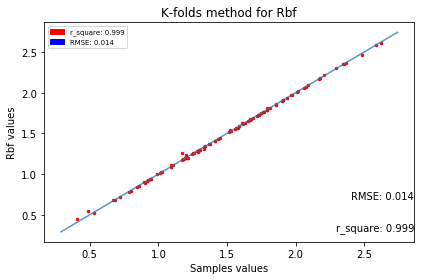

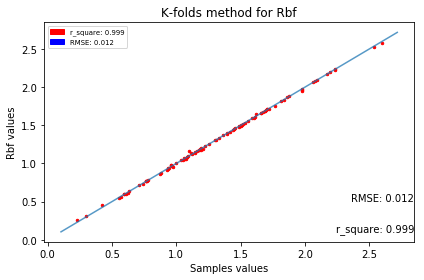

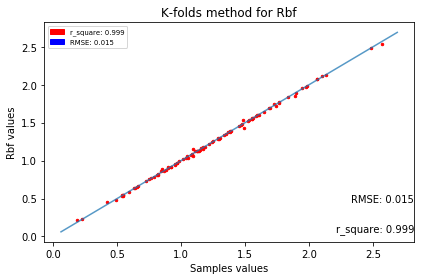

In [8]:
def k_fold_generator(X, y, k_fold,num):
    rbf_result=[]
    #Convert nd.array to list (Once the array is created, th size can't be changed)
    x_rbf = [[]for i in range(num_samples_simulation)]
    for i in range(len(variablenames)):
    	z = X[variablenames[i]].tolist()
    	for j in range((num_samples_simulation)):
    		x_rbf[j].append(z[j])
    subset_size = int(num_samples_simulation / k_fold)
    for k in range(k_fold):
        rbf_train = [[] for i in range(num+1)]
        #Get X train data
        X_train = x_rbf[:k * subset_size] +  x_rbf[(k + 1) * subset_size:]
        X_train = np.array(X_train,dtype='float')
        
        for i in range(num):
        	rbf_train[i] = X_train[:,i].tolist()
        #Get y train data
        y = np.array(y,dtype='float').tolist()
        y_train = y[:k * subset_size] + y[(k + 1) * subset_size:]     
        rbf_train[num] = y_train
        #Get train Rbf model
        train_rbf = Rbf(*rbf_train,function=rbf_function)

        #Get valid data
        rbf_valid = [[] for i in range(num)]
        X_valid =  x_rbf[k * subset_size:][:subset_size]
        X_valid = np.array(X_valid,dtype='float')
        for i in range(num):
        	rbf_valid[i] = X_valid[:,i].tolist()  
        #Get valid result
        rbf_valid_result = train_rbf(*rbf_valid).tolist()
        rbf_result = rbf_result+ rbf_valid_result
    
    rbf_result = np.array(rbf_result,dtype='float')
	
	#Calculate RMSE
    rmse = round(np.sqrt(((rbf_result-y)**2).mean()),3)
    #Calculate r square
    y_bar = np.sum(y)/len(y)  		#Calculate the mean of y
    ssres = np.sum((y-rbf_result)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y-y_bar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    r_square = 1- round(ssres / sstot,3)
	
    #Plot scatter graph
    plt.figure('k-fold method')
    plt.scatter(y,rbf_result,c='r',cmap=plt.cm.coolwarm,zorder=2,s=6)
    plt.xlabel('Samples values')
    plt.ylabel('Rbf values')
    plt.title('K-folds method for Rbf')
    r_square_patch = mpatches.Patch(color='red',label='r_square: %s'%r_square)
    rmse_patch = mpatches.Patch(color='blue',label='RMSE: %s'%rmse )
    plt.legend(handles=[r_square_patch,rmse_patch],loc=0,fontsize = 'x-small')
    #Plot y=x 
    lims = [np.min([plt.gca().get_xlim(),plt.gca().get_ylim()]),np.max([plt.gca().get_xlim(),plt.gca().get_ylim()])] #plt.gca().get_ylim() get lim in y axis
    plt.plot(lims,lims,alpha=0.75)

    #Create text for r_square and RMSE
    plt.text(np.max(plt.gca().get_xlim()),np.min(plt.gca().get_ylim())+0.1,'r_square: %s'%r_square,verticalalignment='bottom', horizontalalignment='right',fontsize= 10)
    plt.text(np.max(plt.gca().get_xlim()),np.min(plt.gca().get_ylim())+0.5,'RMSE: %s'%rmse,verticalalignment='bottom', horizontalalignment='right',fontsize= 10) 
    plt.tight_layout()
    plt.show()
    plt.close()

input_rbf_data = pd.read_csv('input.csv',header=1)
y = [[]for i in range(len(names))]
for i in range(len(names)):
	y[i] = input_rbf_data[names[i]].iloc[:num_samples_simulation]
	k_fold_generator(sample_values,y[i],k_fold,num)


Generate Rbf result

In [9]:
#generate rbf result 
problem={
'num_vars':num,'names':variablenames,'bounds':bounds
} 
if saltelli_second_order == False:
	param_values_GSA = saltelli.sample(problem,int(int(num_samples_saltelli)/(num+2)),calc_second_order=False)  
elif saltelli_second_order == True:
	param_values_GSA = saltelli.sample(problem,int(int(num_samples_saltelli)/(2*num+2)),calc_second_order=True) 

samples_GSA = {}
param_values=[[]for i in range(len(variablenames))]
input_rbf_variables = [[]for i in range(len(variablenames)+1)]
for i in range(len(variablenames)):
	param_values[i]=param_values_GSA[:,i]
	input_rbf_variables[i] = input_rbf_data[variablenames[i]].iloc[:num_samples_simulation]

for i in range(len(names)):
	input_rbf_variables[len(variablenames)] = y[i]
	rbf_GSA_function = Rbf(*input_rbf_variables)
	samples_GSA[names[i]] =  rbf_GSA_function(*param_values)
with open ('output_GSA.csv','w',newline='') as f:
	writer = csv.writer(f)
	writer.writerow(samples_GSA.keys())
	writer.writerows(zip(*samples_GSA.values()))

Sensitivity analysis

In [10]:
def GSA(names=names,saltelli_samples=num_samples_saltelli ):
	#Total data for all names
	#Read data
	input_GSA_input_data = pd.read_csv('output_GSA.csv',header=0)
	#Store names data in seperate list
	input_GSA_names = [[] for i in range(len(names))]
	for i in range(len(names)):
		input_GSA_names[i] = input_GSA_input_data[names[i]].iloc[:num_samples_saltelli]
		input_GSA_names[i] = np.array(input_GSA_names[i],dtype='float')
# # #Sensitivity analysis

	GSA_conf_S1 = [[]for i in range(len(names))]
	GSA_conf_ST = [[]for i in range(len(names))]
	GSA_result_S1 = [[]for i in range(len(names))]
	GSA_result_ST = [[]for i in range(len(names))]

	sobol_analyze_result = [[]for i in range(len(names))]
# 	#sobol_anlyze
	for i in range(len(names)):
		if saltelli_second_order == False:
			sobol_analyze_result[i] = sobol.analyze(problem,input_GSA_names[i],calc_second_order=False)
		elif saltelli_second_order == True:
			sobol_analyze_result[i] = sobol.analyze(problem,input_GSA_names[i],calc_second_order=True)
		#Get S1,ST,Conf result in sobol_analyze_result

		#Get sensitivity analysis result,S1,ST,conf_S1,conf_ST
		GSA_result_S1[i] = sobol_analyze_result[i]['S1']
		GSA_result_ST[i] = sobol_analyze_result[i]['ST']
		GSA_conf_S1[i] = sobol_analyze_result[i]['S1_conf']
		GSA_conf_ST[i] = sobol_analyze_result[i]['ST_conf']


#Plot

	for i in range(len(names)):
		width=0.2
		plt.bar(np.arange(num),GSA_result_S1[i],width,yerr=GSA_conf_S1[i],capsize=7,align='center',alpha=0.5,color='red')
		plt.bar(np.arange(num)+0.3,GSA_result_ST[i],width,yerr=GSA_conf_ST[i],capsize=7,align='center',alpha=0.5,color='blue')
		plt.xticks(np.arange(num),variablenames)
		plt.xlabel('Variables')
		plt.ylabel('Sensitivity_values')
		plt.title('Sensitivity_analysis_'+names[i])
		S1_patch = mpatches.Patch(color='red',label='S1') #create legend
		ST_patch = mpatches.Patch(color='blue',label='ST')
		plt.legend(handles=[S1_patch,ST_patch],loc=1,fontsize = 'x-small')
		plt.tight_layout()
		# graph name = names[i]
		plt.savefig(names[i])
		plt.close()

#xlsx
#Write worksheet
	workbook = xlsxwriter.Workbook('result.xlsx')
	for i in range(len(names)):	
		worksheet_title = workbook.add_worksheet(names[i])
		worksheet_title.write('A1',names[i])
		worksheet_title.write('A2','Variables')
		worksheet_title.write('B2','S1')
		worksheet_title.write('C2','Conf_S1')
		worksheet_title.write('D2','S1_Conf')
		worksheet_title.write('E2','ST')
		worksheet_title.write('F2','Conf_ST')
		worksheet_title.write('G2','ST_Conf')
		worksheet_title.set_column(0,0,25)
		worksheet_title.set_column(3,3,15)
		worksheet_title.set_column(6,6,15)
		#Write result(values) in the grid 
		for row in range(len(variablenames)) :
			worksheet_title.write('A'+str(row+3),variablenames[row])
			worksheet_title.write('B'+str(row+3),sobol_analyze_result[i]['S1'][row])
			worksheet_title.write('C'+str(row+3),sobol_analyze_result[i]['S1_conf'][row])
			worksheet_title.write_string('D'+str(row+3),str([round(sobol_analyze_result[i]['S1'][row]-sobol_analyze_result[i]['S1_conf'][row],3),round(sobol_analyze_result[i]['S1'][row]+sobol_analyze_result[i]['S1_conf'][row],3)]))
			worksheet_title.write('E'+str(row+3),sobol_analyze_result[i]['ST'][row])
			worksheet_title.write('F'+str(row+3),sobol_analyze_result[i]['ST_conf'][row])
			worksheet_title.write_string('G'+str(row+3),str([round(sobol_analyze_result[i]['ST'][row]-sobol_analyze_result[i]['ST_conf'][row],3),round(sobol_analyze_result[i]['ST'][row]+sobol_analyze_result[i]['ST_conf'][row],3)]))
			#insert image
			worksheet_title.insert_image('B'+str(5+len(variablenames)),names[i]+'.png',{'x_scale':0.7,'y_scale':0.7})
			#close the workbook
	workbook.close()
			#remove the graph from folder
	for i in range(len(names)):
		os.remove(names[i]+'.png')

GSA = GSA()







